# Crypto Currencies - Time Series Forecasting
# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [ ]:
# Implement Hyperparameter tunning on the available models.
# Start on creating the classes for the Hybrid Models


In [15]:
#!pip install cryptocmd
#!pip install arch

In [165]:
# Standard library imports
import os
import time
import warnings
import sys
import requests
import pickle
import logging
import joblib


# Third party imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Data Preprocessing and Analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from cryptocmd import CmcScraper

# Deep Learning and Machine Learning Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


# Metrics and Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score
from prettytable import PrettyTable

# Plotting and Visualization
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d
from bokeh.layouts import column
from bokeh.models.widgets import Button
from bokeh.models.callbacks import CustomJS
from bokeh.themes import Theme

# Time Series Analysis and Forecasting
import pmdarima as pm
from arch import arch_model

# Miscellaneous
from joblib import dump, load
from math import pi

# Warnings and Logging
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)


# Block 1. - CryptoDate

In [166]:
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.

    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.

    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        logging.info("Initializing CryptoData class")
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        logging.info(f"Fetching {self.crypto_symbol} data")
        try:
            scraper = CmcScraper(self.crypto_symbol)
            df = scraper.get_dataframe()
            if not {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}.issubset(df.columns):
                raise ValueError("Some expected columns are missing in the data.")
            logging.info(f"Data fetched successfully for {self.crypto_symbol}")
            return df
        except Exception as e:
            logging.error(f'An error occurred while fetching data: {e}')
            raise  # Propagate the exception

    def get_cryptocmd_data(self) -> pd.DataFrame:
        logging.info(f"Getting {self.crypto_symbol} data")
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        logging.info(f"Data obtained successfully for {self.crypto_symbol}")
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        logging.info(f"Formatting display data for {self.crypto_symbol}")
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)

        # Check and apply volume formatting only if they are of numeric type
        volume_like_columns = ['Volume', 'Market Cap']
        for column in volume_like_columns:
            if pd.api.types.is_numeric_dtype(display_df[column]):
                display_df[column] = display_df[column].apply(self._format_volume_value)

        logging.info(f"Display data formatted successfully for {self.crypto_symbol}")
        return display_df


In [167]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
data

2023-07-16 23:52:05,041 [INFO] - Initializing CryptoData class
2023-07-16 23:52:05,042 [INFO] - Getting BTC data
2023-07-16 23:52:05,043 [INFO] - Fetching BTC data
2023-07-16 23:52:08,553 [INFO] - Data fetched successfully for BTC
2023-07-16 23:52:08,560 [INFO] - Data obtained successfully for BTC


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-07-15,30331.780,30407.780,30263.460,30295.810,8011667755.870,588656416080.430
2023-07-14,31474.720,31582.250,29966.390,30334.070,20917902659.760,589374459085.890
2023-07-13,30387.490,31814.510,30268.350,31476.050,23686079547.520,611535352757.700
2023-07-12,30622.250,30959.970,30228.840,30391.650,14805659716.840,590443005305.010
2023-07-11,30417.630,30788.310,30358.100,30620.950,12151839151.900,594872050276.470
...,...,...,...,...,...,...
2013-05-02,116.380,125.600,92.280,105.210,0.000,1168517495.250
2013-05-01,139.000,139.890,107.720,116.990,0.000,1298954593.750
2013-04-30,144.000,146.930,134.050,139.000,0.000,1542813125.000


# ------------------------------------------------------------------------------------------------------------------------------------------

In [168]:
# Block 2 - Crypto analytics
class CryptoAnalytics:
    """
    This class is responsible for performing analytics on cryptocurrency data.

    Input:
        df (pd.DataFrame): The DataFrame containing the cryptocurrency data.

    Methods:
        get_all_time_records: Returns the all-time high and low closing prices.
        get_yearly_analysis: Returns yearly high, low, average, and variation.
        get_monthly_analysis: Returns monthly high, low, average, and variation.
        get_weekly_analysis: Returns weekly high, low, average, and variation.
    """
    def __init__(self, crypto_data: CryptoData):
        logger.info("Initializing CryptoAnalytics class")
        self.df = crypto_data.get_cryptocmd_data()

    def format_and_round(self, number):
        return f'{number:,.2f}'

    def apply_custom_formatting(self, data):
        logger.info("Applying custom formatting")
        ordered_columns = [
            'Open_first', 'Close_last', 'variation_$_abs',
            'variation_%_rel', 'Close_min', 'Close_mean', 'Close_max'
        ]
        data = data[ordered_columns]
        return data

    def get_all_time_records(self):
        logger.info("Getting all time records")
        all_time_high = self.df['Close'].max()
        all_time_low = self.df['Close'].min()
        all_time_high_date = self.df['Close'].idxmax().strftime('%Y-%m-%d')
        all_time_low_date = self.df['Close'].idxmin().strftime('%Y-%m-%d')
        return all_time_high, all_time_low, all_time_high_date, all_time_low_date

    def get_yearly_analysis(self):
        logger.info("Getting yearly analysis")
        yearly_data = self.df.resample('Y').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        yearly_data.columns = yearly_data.columns.map('_'.join).str.strip('_')
        yearly_data = self.calculate_variation(yearly_data)
        return self.apply_custom_formatting(yearly_data)

    def get_monthly_analysis(self):
        logger.info("Getting monthly analysis")
        monthly_data = self.df.resample('M').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        monthly_data.columns = monthly_data.columns.map('_'.join).str.strip('_')
        monthly_data = self.calculate_variation(monthly_data)
        return self.apply_custom_formatting(monthly_data)

    def get_weekly_analysis(self):
        logger.info("Getting weekly analysis")
        weekly_data = self.df.resample('W').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        weekly_data.columns = weekly_data.columns.map('_'.join).str.strip('_')
        weekly_data = self.calculate_variation(weekly_data)
        return self.apply_custom_formatting(weekly_data)

    def calculate_variation(self, data):
        logger.info("Calculating variation")
        data['variation_$_abs'] = data['Close_last'] - data['Open_first']
        data['variation_%_rel'] = ((data['Close_last'] - data['Open_first']) / data['Open_first']) * 100
        return data

    def display_all_analyses(self):
        logger.info("Displaying all analyses")
        all_time_high, all_time_low, all_time_high_date, all_time_low_date = self.get_all_time_records()
        print(f"All Time High: {self.format_and_round(all_time_high)} (Date: {all_time_high_date})")
        print(f"All Time Low: {self.format_and_round(all_time_low)} (Date: {all_time_low_date})")

        print("\nYearly Analysis:")
        display(self.get_yearly_analysis())

        print("\nMonthly Analysis:")
        display(self.get_monthly_analysis())

        print("\nWeekly Analysis:")
        display(self.get_weekly_analysis())


In [169]:
# Create an instance of CryptoAnalytics
analytics = CryptoAnalytics(crypto)
# Display all analyses
analytics.display_all_analyses()

2023-07-16 23:52:08,621 [INFO] - Initializing CryptoAnalytics class
2023-07-16 23:52:08,622 [INFO] - Getting BTC data
2023-07-16 23:52:08,623 [INFO] - Fetching BTC data
2023-07-16 23:52:10,253 [INFO] - Data fetched successfully for BTC
2023-07-16 23:52:10,257 [INFO] - Data obtained successfully for BTC
2023-07-16 23:52:10,261 [INFO] - Displaying all analyses
2023-07-16 23:52:10,262 [INFO] - Getting all time records
2023-07-16 23:52:10,263 [INFO] - Getting yearly analysis
2023-07-16 23:52:10,274 [INFO] - Calculating variation
2023-07-16 23:52:10,276 [INFO] - Applying custom formatting


All Time High: 67,566.83 (Date: 2021-11-08)
All Time Low: 68.43 (Date: 2013-07-05)

Yearly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-12-31,136.690,754.010,617.320,451.620,68.430,257.449,1151.170
2014-12-31,754.970,320.190,-434.780,-57.589,310.740,527.237,953.290
2015-12-31,320.430,430.570,110.140,34.373,178.100,272.453,465.320
2016-12-31,430.720,963.740,533.020,123.751,364.330,568.492,975.920
2017-12-31,963.660,14156.400,13192.740,1369.024,777.760,4006.034,19497.400
2018-12-31,14112.200,3742.700,-10369.500,-73.479,3236.760,7572.299,17527.000
2019-12-31,3746.710,7193.600,3446.890,91.998,3399.470,7395.247,13016.230
2020-12-31,7194.890,29001.720,21806.830,303.088,4970.790,11116.378,29001.720
2021-12-31,28994.010,46306.450,17312.440,59.710,29374.150,47436.932,67566.830


2023-07-16 23:52:10,284 [INFO] - Getting monthly analysis
2023-07-16 23:52:10,292 [INFO] - Calculating variation
2023-07-16 23:52:10,294 [INFO] - Applying custom formatting



Monthly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-30,136.690,139.000,2.310,1.690,127.950,137.163,144.540
2013-05-31,139.000,129.000,-10.000,-7.194,97.750,119.993,133.480
2013-06-30,128.820,96.610,-32.210,-25.004,94.650,107.761,129.300
2013-07-31,97.510,106.090,8.580,8.799,68.430,90.512,107.990
2013-08-31,106.210,135.350,29.140,27.436,102.800,113.905,135.350
...,...,...,...,...,...,...,...
2023-03-31,23150.930,28478.480,5327.550,23.012,20187.240,25116.901,28478.480
2023-04-30,28473.330,29268.810,795.480,2.794,27276.910,28857.574,30485.700
2023-05-31,29227.100,27219.660,-2007.440,-6.868,26334.820,27499.307,29534.380


2023-07-16 23:52:10,304 [INFO] - Getting weekly analysis
2023-07-16 23:52:10,316 [INFO] - Calculating variation
2023-07-16 23:52:10,319 [INFO] - Applying custom formatting



Weekly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-28,136.690,127.950,-8.740,-6.394,127.950,127.950,127.950
2013-05-05,134.440,115.910,-18.530,-13.783,97.750,118.843,144.540
2013-05-12,115.980,115.000,-0.980,-0.845,111.500,113.926,117.200
2013-05-19,114.820,121.990,7.170,6.245,111.500,118.709,123.500
2013-05-26,122.500,133.480,10.980,8.963,122.000,127.733,133.480
...,...,...,...,...,...,...,...
2023-06-18,25934.290,26336.210,401.920,1.550,25124.680,25956.664,26510.680
2023-06-25,26335.440,30480.260,4144.820,15.739,26851.030,29548.931,30695.470
2023-07-02,30480.520,30620.770,140.250,0.460,30086.250,30454.141,30688.160


# ------------------------------------------------------------------------------------------------------------------------------------------

In [170]:
# block 3
class CryptoVisual:
    """
    This class is responsible for creating candlestick charts with a moving average line using Bokeh.

    Input:
        data (pd.DataFrame): DataFrame containing OHLC data with 'Date' as the index.

    Methods:
        create_candlestick_chart: Creates a candlestick chart with a moving average line using Bokeh.
        create_line_chart: Creates a line chart with a moving average line using Bokeh.
    """
    def __init__(self, data: pd.DataFrame):
        logger.info("Initializing CryptoVisual class")
        self.data = data

    def create_candlestick_chart(self, time_period='last_month', ma_period=20):
        logger.info("Creating candlestick chart")
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        inc = df.Close > df.Open
        dec = df.Open > df.Close

        # Create separate ColumnDataSources for positive and negative daily variations
        source_inc = ColumnDataSource(df[inc])
        source_dec = ColumnDataSource(df[dec])
        source_hover = ColumnDataSource(df)

        w = 12 * 60 * 60 * 1000  # half day in ms

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

        p = figure(x_axis_type="datetime", tools=TOOLS, width=950, title="Crypto Candlestick with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot positive daily variations (green)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_inc)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#39B86B", line_color="black", source=source_inc)

        # Plot negative daily variations (red)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_dec)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#F2583E", line_color="black", source=source_dec)

        # Enable scroll wheel zoom
        p.toolbar.active_scroll = p.select_one(WheelZoomTool)

        # Add hover tool
        hover = HoverTool(
            tooltips=[
                ("Date", "@index_col{%F}"),  # date hover label
                ("Open", "@{Open}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Close", "@{Close}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("High", "@{High}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Low", "@{Low}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("MA", "@{MA}{($ 0,0.00)}"),  # moving average hover label
            ],
            formatters={
                '@index_col': 'datetime',  # format date hover label as date
                '@Open': 'numeral',  # format numerical data
                '@Close': 'numeral',  # format numerical data
                '@High': 'numeral',  # format numerical data
                '@Low': 'numeral',  # format numerical data
                '@MA': 'numeral',
            },
            mode='vline'  # display a tooltip whenever the cursor is vertically in line with a glyph
        )
        p.add_tools(hover)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source_hover)

        show(p)  # open a browser

    def create_line_chart(self, time_period='last_month', ma_period=20):
        logger.info("Creating line chart")
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        source = ColumnDataSource(df)

        p = figure(x_axis_type="datetime", tools="pan,wheel_zoom,box_zoom,reset,save", width=950, title="Crypto Line Chart with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot line chart
        p.line('index_col', 'Close', color='black', legend_label='Close', source=source)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source)

        show(p)  # open a browser

    def _select_data(self, time_period):
        logger.info("Selecting data for time period: %s", time_period)
        if time_period == 'last_month':
            last_month = self.data.index.max() - pd.DateOffset(months=1)
            df = self.data[self.data.index >= last_month]
        elif time_period == 'last_3_months':
            last_3_months = self.data.index.max() - pd.DateOffset(months=3)
            df = self.data[self.data.index >= last_3_months]
        elif time_period == 'last_6_months':
            last_6_months = self.data.index.max() - pd.DateOffset(months=6)
            df = self.data[self.data.index >= last_6_months]
        elif time_period == 'last_1_year':
            last_1_year = self.data.index.max() - pd.DateOffset(years=1)
            df = self.data[self.data.index >= last_1_year]
        elif time_period == 'last_3_years':
            last_3_years = self.data.index.max() - pd.DateOffset(years=3)
            df = self.data[self.data.index >= last_3_years]
        else:
            df = self.data

        return df


In [171]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create candlestick chart
crypto_visual.create_candlestick_chart(time_period='last_6_months', ma_period=20)

2023-07-16 23:52:10,375 [INFO] - Initializing CryptoData class
2023-07-16 23:52:10,377 [INFO] - Getting BTC data
2023-07-16 23:52:10,378 [INFO] - Fetching BTC data
2023-07-16 23:52:11,167 [INFO] - Data fetched successfully for BTC
2023-07-16 23:52:11,171 [INFO] - Data obtained successfully for BTC
2023-07-16 23:52:11,176 [INFO] - Initializing CryptoVisual class
2023-07-16 23:52:11,209 [INFO] - Creating candlestick chart
2023-07-16 23:52:11,210 [INFO] - Selecting data for time period: last_6_months


In [172]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create line chart
crypto_visual.create_line_chart(time_period='all', ma_period=20)

2023-07-16 23:52:11,773 [INFO] - Initializing CryptoData class
2023-07-16 23:52:11,774 [INFO] - Getting BTC data
2023-07-16 23:52:11,778 [INFO] - Fetching BTC data
2023-07-16 23:52:12,892 [INFO] - Data fetched successfully for BTC
2023-07-16 23:52:12,898 [INFO] - Data obtained successfully for BTC
2023-07-16 23:52:12,901 [INFO] - Initializing CryptoVisual class
2023-07-16 23:52:12,903 [INFO] - Creating line chart
2023-07-16 23:52:12,904 [INFO] - Selecting data for time period: all


In [173]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

2023-07-16 23:52:13,191 [INFO] - Initializing CryptoData class
2023-07-16 23:52:13,194 [INFO] - Getting BTC data
2023-07-16 23:52:13,195 [INFO] - Fetching BTC data
2023-07-16 23:52:14,368 [INFO] - Data fetched successfully for BTC
2023-07-16 23:52:14,373 [INFO] - Data obtained successfully for BTC


# ------------------------------------------------------------------------------------------------------------------------------------------

In [174]:
class TimeSeriesAnalysis:
    """
    This class provides methods for performing time series analysis on cryptocurrency data.

    Input:
        data (pd.Series or array-like): Time series data to be analyzed.

    Methods:
        check_stationarity: Checks the stationarity of the time series using the Augmented Dickey-Fuller test.
        check_autocorrelation: Plots the autocorrelation and partial autocorrelation functions of the time series.
        check_volatility: Fits a GARCH(1,1) model to the time series and prints the model summary.
    """
    def __init__(self, data, target):
        logger.info("Initializing TimeSeriesAnalysis class")
        self.data = data
        self.target = target
        
    def check_stationarity(self):
        logger.info("Checking stationarity of the time series")
        result = adfuller(self.data[self.target])
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[1] <= 0.05:
            print('The series is likely stationary.')
        else:
            print('The series is likely non-stationary.')

    def check_autocorrelation(self):
        logger.info("Checking autocorrelation of the time series")
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
        data1D = self.data[self.target].values   # Convert DataFrame to 1D numpy array
        plot_acf(data1D, lags=50, alpha=0.05, ax=ax1)
        plt.title("ACF for Close Price", size=20)

        plot_pacf(data1D, lags=50, alpha=0.05, method='ols', ax=ax2)
        plt.title("PACF for Close Price -- Daily", size=20)


    def check_volatility(self):
        logger.info("Checking volatility of the time series")
        model = arch_model(self.data[self.target], vol='Garch', p=1, q=1)
        model_fit = model.fit()
        print(model_fit.summary())
    
    def decompose_time_series(self, model='additive', period=30):
        logger.info("Decomposing the time series")
        result = seasonal_decompose(self.data[self.target], model=model, period=period)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonal')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residual')
        
        plt.tight_layout()
        plt.show()
        
    def test_granger_causality(self, other_column, maxlag=30):
        logger.info("Testing Granger causality")
        other_data = self.data[other_column].values
        target_data = self.data[self.target].values
        data = np.column_stack((target_data, other_data))
        result = grangercausalitytests(data, maxlag=maxlag)
        return result
 

2023-07-16 23:52:14,456 [INFO] - Initializing TimeSeriesAnalysis class
2023-07-16 23:52:14,459 [INFO] - Checking stationarity of the time series
2023-07-16 23:52:14,761 [INFO] - Checking volatility of the time series
2023-07-16 23:52:14,834 [INFO] - Checking autocorrelation of the time series


ADF Statistic: -1.676407
p-value: 0.443308
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The series is likely non-stationary.
Iteration:      1,   Func. Count:      6,   Neg. LLF: 125401.38717265216
Iteration:      2,   Func. Count:     12,   Neg. LLF: 39280.390839788335
Iteration:      3,   Func. Count:     17,   Neg. LLF: 39280.25504167478
Iteration:      4,   Func. Count:     22,   Neg. LLF: 39279.70755753936
Iteration:      5,   Func. Count:     27,   Neg. LLF: 39278.78449214932
Iteration:      6,   Func. Count:     32,   Neg. LLF: 39277.8281532545
Iteration:      7,   Func. Count:     37,   Neg. LLF: 39274.468413521325
Iteration:      8,   Func. Count:     42,   Neg. LLF: 39268.65165849998
Iteration:      9,   Func. Count:     47,   Neg. LLF: 39240.78784074153
Iteration:     10,   Func. Count:     52,   Neg. LLF: 39100.642466951955
Iteration:     11,   Func. Count:     57,   Neg. LLF: 38476.9006454747
Iteration:     12,   Func. Count:     62,   Neg. LLF: 37647.524613343165

2023-07-16 23:52:15,156 [INFO] - Decomposing the time series


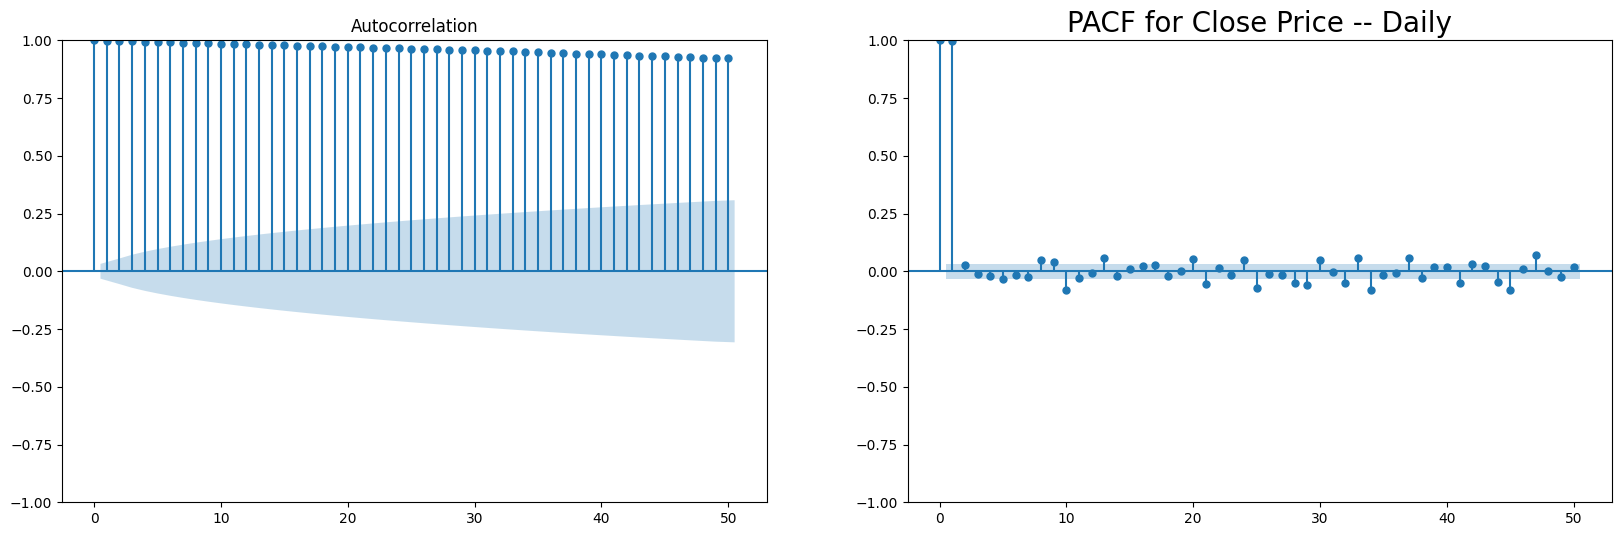

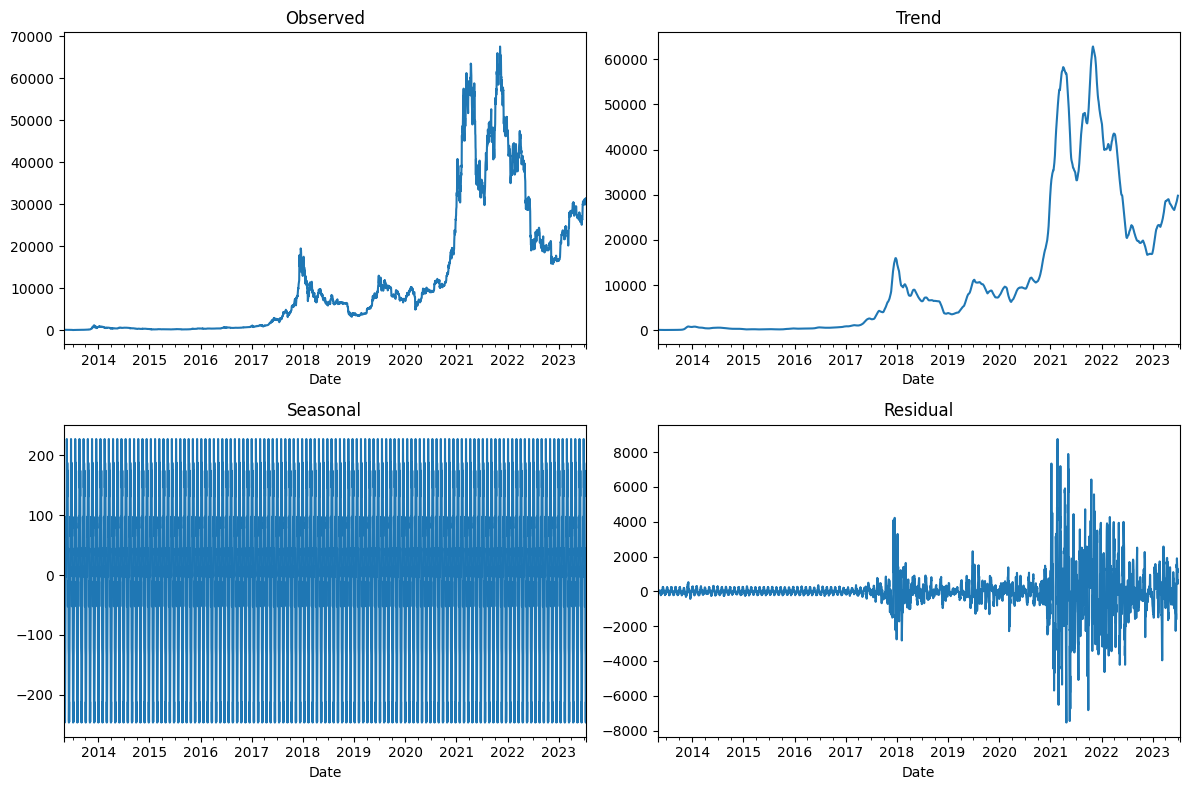

2023-07-16 23:52:16,180 [INFO] - Testing Granger causality



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=828563.7284, p=0.0000  , df_denom=3727, df_num=1
ssr based chi2 test:   chi2=829230.6699, p=0.0000  , df=1
likelihood ratio test: chi2=20173.9967, p=0.0000  , df=1
parameter F test:         F=828563.7284, p=0.0000  , df_denom=3727, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=427758.0712, p=0.0000  , df_denom=3724, df_num=2
ssr based chi2 test:   chi2=856664.7945, p=0.0000  , df=2
likelihood ratio test: chi2=20290.4216, p=0.0000  , df=2
parameter F test:         F=427758.0712, p=0.0000  , df_denom=3724, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=284942.9951, p=0.0000  , df_denom=3721, df_num=3
ssr based chi2 test:   chi2=856437.1022, p=0.0000  , df=3
likelihood ratio test: chi2=20284.9891, p=0.0000  , df=3
parameter F test:         F=284942.9951, p=0.0000  , df_denom=3721, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

{1: ({'ssr_ftest': (828563.7283872463, 0.0, 3727.0, 1),
   'ssr_chi2test': (829230.6699448427, 0.0, 1),
   'lrtest': (20173.996657817188, 0.0, 1),
   'params_ftest': (828563.728387245, 0.0, 3727.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (427758.0711509808, 0.0, 3724.0, 2),
   'ssr_chi2test': (856664.7944801328, 0.0, 2),
   'lrtest': (20290.421562507712, 0.0, 2),
   'params_ftest': (427758.0711509806, 0.0, 3724.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (284942.9951184395, 0.0, 3721.0, 3),
   'ssr_chi2test': (856437.1022318266, 0.0, 3),
   'lrtest': (20284.98914604357, 0.0, 3),
   'params_ftest': (284942.9951184389, 0.0, 3721.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (213424.51129845914, 0.0, 3718.0, 4),
   'ssr_chi2test': (855764.5547168987, 0.0, 4),
   'lrtest': (20277.62820955098, 0.0, 4),
   'params_ftest'

In [175]:
# Create an instance of the TimeSeriesAnalysis class
tsa = TimeSeriesAnalysis(data,target='Close')
tsa.check_stationarity()
tsa.check_volatility()
tsa.check_autocorrelation()
tsa.decompose_time_series()
tsa.test_granger_causality('Open', maxlag=30)

# ------------------------------------------------------------------------------------------------------------------------------------------

In [176]:
class DataPreprocessing:
    def __init__(self, data, target_columns, seq_length=5, scaler_path='./scaler.pkl'):
        logger.info("Initializing DataPreprocessing class")
        
        # Check if target_columns exist in data
        if not set(target_columns).issubset(data.columns):
            logger.error(f"Target columns {target_columns} not found in data.")
            raise ValueError(f"Target columns {target_columns} not found in data.")
        
        self.data = data.sort_index(ascending=True)
        self.target_columns = target_columns
        self.seq_length = seq_length
        self.scaler = StandardScaler()
        self.scaler_path = scaler_path

        # If a scaler file exists, load it. Otherwise, fit a new scaler
        if os.path.exists(self.scaler_path):
            self.load_scaler()
            self.data_scaled = self.scaler.transform(self.data[self.target_columns])
        else:
            self.data_scaled = self.scaler.fit_transform(self.data[self.target_columns])
            self.save_scaler()

    def save_scaler(self):
        logger.info("Saving scaler")
        joblib.dump(self.scaler, self.scaler_path)
        logger.info(f"Scaler saved to {self.scaler_path}")

    def load_scaler(self):
        logger.info("Loading scaler")
        try:
            self.scaler = joblib.load(self.scaler_path)
            logger.info(f"Scaler loaded from {self.scaler_path}")
        except Exception as e:
            logger.error(f"Error loading scaler from {self.scaler_path}: {e}")
            raise

    def split_data(self, test_size=0.2):
        logger.info("Splitting data")
        train_data, test_data = train_test_split(self.data_scaled, test_size=test_size, shuffle=False)
        return train_data, test_data

    def prepare_data_rnn(self, data):
        logger.info("Preparing data for RNN")
        X, y = [], []
        for i in range(self.seq_length, len(data)):
            X.append(data[i-self.seq_length:i])
            y.append(data[i, 0])
        X, y = np.array(X), np.array(y)
        logger.info(f"RNN Data Shape - X: {X.shape}, y: {y.shape}")
        return X, y   

    def prepare_data_for_tree_based_model(self, target_column='Close', test_size=0.2, scale=False):
        logger.info("Preparing data for tree-based model")
        X = self.data.drop(target_column, axis=1)
        y = self.data[target_column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False)

        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        logger.info(f"Tree Data Shape - X: {X_train.shape}, {y_train.shape} , y: {X_test.shape}, {y_test.shape}")
        return X_train, y_train, X_test, y_test

    def visualize_split(self, train_data, test_data):
        logger.info("Visualizing data split")
        plt.figure(figsize=(14, 7))
        plt.plot(np.arange(len(train_data)), self.scaler.inverse_transform(train_data)[:, 0], color='blue', label='Training Data')
        plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), self.scaler.inverse_transform(test_data)[:, 0], color='orange', label='Testing Data')
        plt.xlabel('Time Step')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.show()

    def prepare_data_SARIMAX(self, target_column='Close', exog_columns=None, test_size=0.2):
        logger.info("Preparing data for SARIMAX")
        y = self.data[target_column]
        X = self.data[exog_columns] if exog_columns else None

        y_train, y_test = train_test_split(y, test_size=test_size, shuffle=False)
        X_train, X_test = train_test_split(X, test_size=test_size, shuffle=False) if X is not None else (None, None)

        logger.info(f"SARIMAX Data Shape - y: {y_train.shape}, {y_test.shape}")
        return y_train, y_test, X_train, X_test

    def prepare_data_deepar(self):
        logger.info("Preparing data for DeepAR")
        # Add your preferred method to prepare data for AutoTS model
        pass

    def prepare_data_deeptime(self):
        logger.info("Preparing data for DeepTime")
        # Add your preferred method to prepare data for DeepTime model
        pass

In [177]:
# Assuming 'Close' is your target column
preprocessor = DataPreprocessing(data, ['Close'])
scaled_data = preprocessor.data_scaled
train_data, test_data = preprocessor.split_data(test_size=0.2)
#preprocessor.visualize_split(train_data, test_data)
X_train_rnn, y_train_rnn = preprocessor.prepare_data_rnn(train_data)
X_test_rnn, y_test_rnn = preprocessor.prepare_data_rnn(test_data)

2023-07-16 23:52:17,322 [INFO] - Initializing DataPreprocessing class
2023-07-16 23:52:17,327 [INFO] - Loading scaler
2023-07-16 23:52:17,329 [INFO] - Scaler loaded from ./scaler.pkl
2023-07-16 23:52:17,334 [INFO] - Splitting data
2023-07-16 23:52:17,335 [INFO] - Preparing data for RNN
2023-07-16 23:52:17,369 [INFO] - RNN Data Shape - X: (2979, 5, 1), y: (2979,)
2023-07-16 23:52:17,370 [INFO] - Preparing data for RNN
2023-07-16 23:52:17,372 [INFO] - RNN Data Shape - X: (742, 5, 1), y: (742,)


In [178]:
preprocessor = DataPreprocessing(data, ['Close'])
scaled_data = preprocessor.data_scaled
train_data, test_data = preprocessor.split_data(test_size=0.2)
# For Linear Regression
X_train_lr, y_train_lr, X_test_lr, y_test_lr = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=True)
# For XGBoost
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=False)
# For LightGBM
X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=False)

2023-07-16 23:52:17,384 [INFO] - Initializing DataPreprocessing class
2023-07-16 23:52:17,389 [INFO] - Loading scaler
2023-07-16 23:52:17,392 [INFO] - Scaler loaded from ./scaler.pkl
2023-07-16 23:52:17,396 [INFO] - Splitting data
2023-07-16 23:52:17,397 [INFO] - Preparing data for tree-based model
2023-07-16 23:52:17,404 [INFO] - Tree Data Shape - X: (2984, 5), (2984,) , y: (747, 5), (747,)
2023-07-16 23:52:17,405 [INFO] - Preparing data for tree-based model
2023-07-16 23:52:17,408 [INFO] - Tree Data Shape - X: (2984, 5), (2984,) , y: (747, 5), (747,)
2023-07-16 23:52:17,409 [INFO] - Preparing data for tree-based model
2023-07-16 23:52:17,413 [INFO] - Tree Data Shape - X: (2984, 5), (2984,) , y: (747, 5), (747,)


# ------------------------------------------------------------------------------------------------------------------------------------------

# Block X - LSTM Class

In [179]:
class LSTM_Models:
    def __init__(self, input_shape, units, dropout, dense_units, optimizer, scaler, X_train, y_train, X_test, y_test,cross_val=False):
        logging.info("Initializing LSTM model")
        self.model = Sequential()
        for i, unit in enumerate(units):
            return_sequences = True if i < len(units) - 1 else False
            self.model.add(LSTM(units=unit, input_shape=input_shape, return_sequences=return_sequences))
            self.model.add(Dropout(dropout))
        self.model.add(Dense(units=dense_units))
        self.model.compile(optimizer=optimizer, loss='mean_squared_error')
        self.model.summary()
        self.cross_val = cross_val
        self.scaler = scaler
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.params = {
            'input_shape': input_shape,
            'units': units,
            'dropout': dropout,
            'dense_units': dense_units,
            'optimizer': optimizer
        }

    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        logging.info("Training LSTM model")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None
        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            self.history = []
            fold_no = 1
            for train, val in tscv.split(self.X_train):
                logging.info(f"Training on fold {fold_no}")
                history = self.model.fit(self.X_train[train], self.y_train[train], epochs=epochs, 
                                         batch_size=batch_size, validation_data=(self.X_train[val], self.y_train[val]), 
                                         callbacks=callbacks, shuffle=False)
                self.history.append(history)
                logging.info(f"Done with fold {fold_no}")
                fold_no += 1
        else:
            self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, 
                                          batch_size=batch_size, validation_split=0.2, 
                                          callbacks=callbacks, shuffle=False)
        logging.info("Training completed")

    def make_predictions(self):
        logging.info("Making predictions with LSTM model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

        # Unscaled the predictions
        self.train_predictions = self.scaler.inverse_transform(self.train_predictions)
        self.test_predictions = self.scaler.inverse_transform(self.test_predictions)

        self.train_comparison_df = pd.DataFrame({'Actual': self.scaler.inverse_transform(self.y_train.reshape(-1, 1)).flatten(), 
                                                 'Predicted': self.train_predictions.squeeze()})
        self.test_comparison_df = pd.DataFrame({'Actual': self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten(), 
                                                'Predicted': self.test_predictions.squeeze()})
        logging.info("Predictions made")

    def evaluate_model(self):
        logging.info("Evaluating LSTM model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.train_comparison_df['Actual'], 
                                          self.train_comparison_df['Predicted'], 
                                          squared=False)
                test_evaluation = metric(self.test_comparison_df['Actual'], 
                                         self.test_comparison_df['Predicted'], 
                                         squared=False)
            else:
                train_evaluation = metric(self.train_comparison_df['Actual'], 
                                          self.train_comparison_df['Predicted'])
                test_evaluation = metric(self.test_comparison_df['Actual'], 
                                         self.test_comparison_df['Predicted'])
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        logging.info("Evaluation completed")
        return self.evaluation_df

    def plot_history(self):
        logging.info("Plotting training history")
        plt.figure(figsize=(14, 7))

        if self.cross_val:
            # Loop through the history of each fold
            for i, history in enumerate(self.history):
                plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
                plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
        else:
            plt.plot(self.history.history['loss'], label='Training Loss')
            plt.plot(self.history.history['val_loss'], label='Validation Loss')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        logging.info("Plotting completed")

    def plot_predictions(self):
        logging.info("Plotting predictions")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        axes[0].plot(self.train_comparison_df['Actual'], label='Actual')
        axes[0].plot(self.train_comparison_df['Predicted'], label='Predicted')
        axes[0].set_title('Training Data')
        axes[0].legend()

        axes[1].plot(self.test_comparison_df['Actual'], label='Actual')
        axes[1].plot(self.test_comparison_df['Predicted'], label='Predicted')
        axes[1].set_title('Testing Data')
        axes[1].legend()

        plt.show()
        logging.info("Plotting completed")
            
    def save_model(self):
        # Create a model name based on the parameters
        model_name = f"LSTM_model_{str(self.params).replace(' ', '').replace(':', '').replace(',', '_')}.h5"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        self.model.save(model_path)
        logging.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load_model(model_path)
        logging.info(f"Model loaded from {model_path}")
        return loaded_model

# Block X - LSTM Models 

In [180]:
# After preparing your data with the DataPreprocessing class...
lstm_model = LSTM_Models(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), 
                         units=[256, 128], 
                         dropout=0.2, 
                         dense_units=1, 
                         optimizer='adam', 
                         scaler=preprocessor.scaler, 
                         X_train=X_train_rnn, 
                         y_train=y_train_rnn, 
                         X_test=X_test_rnn, 
                         y_test=y_test_rnn,
                        cross_val=False)

lstm_model.train_model(epochs=100, batch_size=32, early_stopping=True)
lstm_model.save_model()  # save the model
lstm_model.make_predictions()

2023-07-16 23:52:17,460 [INFO] - Initializing LSTM model


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 5, 256)            264192    
                                                                 
 dropout_29 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_30 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


2023-07-16 23:52:18,045 [INFO] - Training LSTM model


Epoch 1/100
75/75 [==============================] - 5s 29ms/step - loss: 0.0347 - val_loss: 0.0786
Epoch 2/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0027 - val_loss: 0.0164
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 0.0584
Epoch 4/100
75/75 [==============================] - 1s 16ms/step - loss: 0.0030 - val_loss: 0.0219
Epoch 5/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0406
Epoch 6/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0349
Epoch 7/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0337
Epoch 8/100
75/75 [==============================] - 1s 15ms/step - loss: 0.0029 - val_loss: 0.0220
Epoch 9/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0348
Epoch 10/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0622

2023-07-16 23:52:34,346 [INFO] - Training completed
2023-07-16 23:52:34,399 [INFO] - Model saved at trained_models\LSTM_model_{'input_shape'(5_1)_'units'[256_128]_'dropout'0.2_'dense_units'1_'optimizer''adam'}.h5
2023-07-16 23:52:34,399 [INFO] - Making predictions with LSTM model


24/24 [==============================] - 0s 4ms/step


2023-07-16 23:52:35,958 [INFO] - Predictions made


2023-07-16 23:52:35,968 [INFO] - Evaluating LSTM model
2023-07-16 23:52:35,976 [INFO] - Evaluation completed
2023-07-16 23:52:35,977 [INFO] - Plotting training history


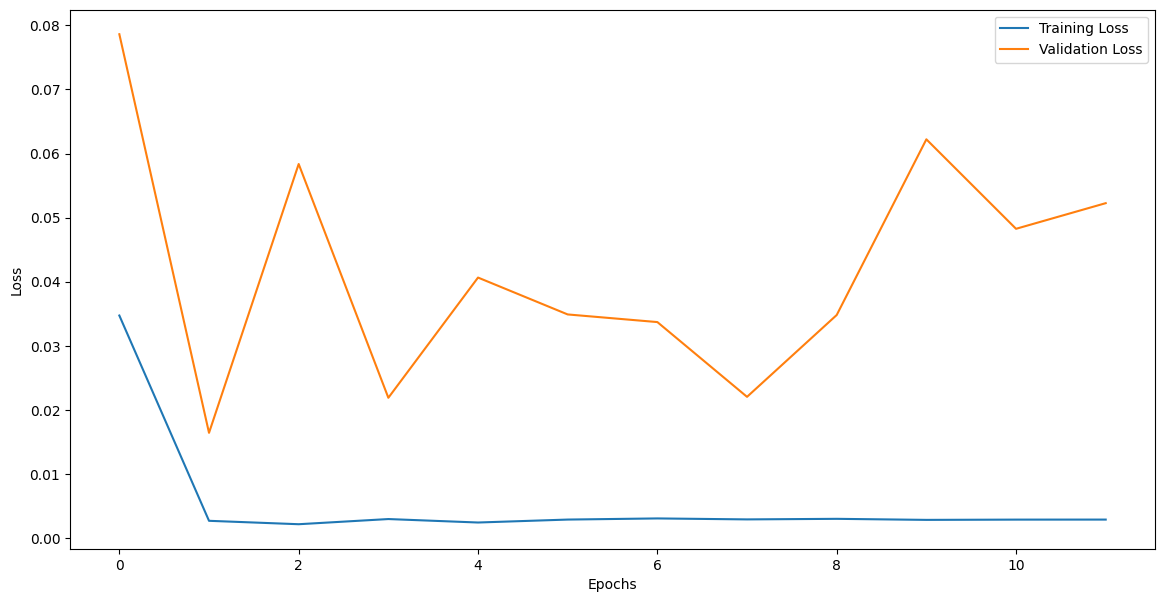

2023-07-16 23:52:36,158 [INFO] - Plotting completed
2023-07-16 23:52:36,160 [INFO] - Plotting predictions


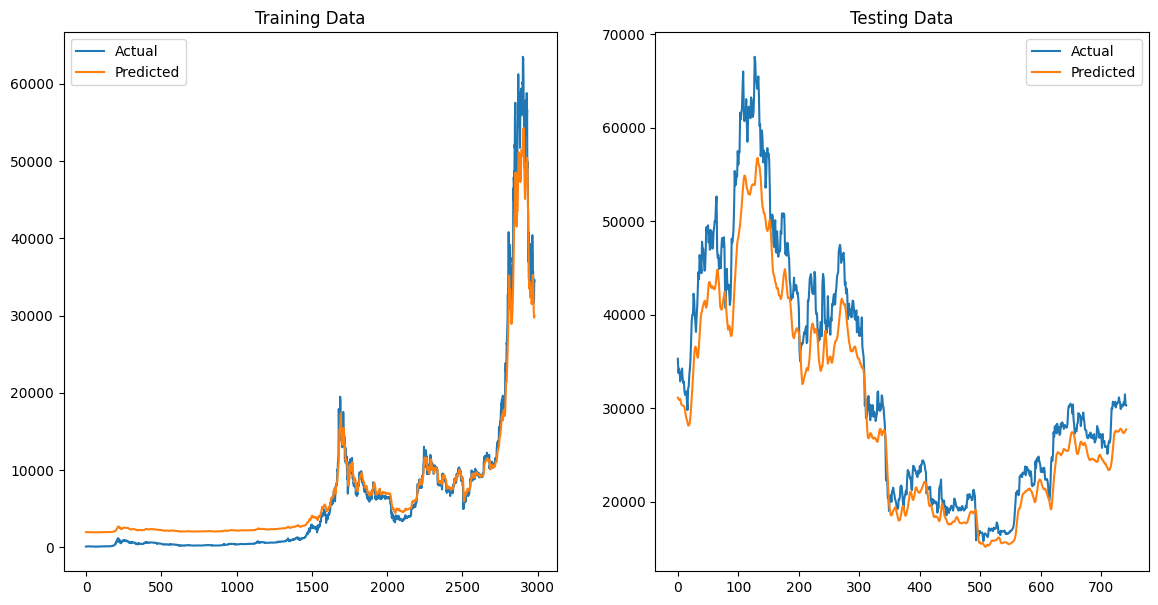

2023-07-16 23:52:36,445 [INFO] - Plotting completed


In [181]:
lstm_model.evaluate_model()
lstm_model.plot_history()
lstm_model.plot_predictions()

In [182]:
# After preparing your data with the DataPreprocessing class...
lstm_model1 = LSTM_Models(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), 
                         units=[256], 
                         dropout=0.2, 
                         dense_units=1, 
                         optimizer='adam', 
                         scaler=preprocessor.scaler, 
                         X_train=X_train_rnn, 
                         y_train=y_train_rnn, 
                         X_test=X_test_rnn, 
                         y_test=y_test_rnn)

lstm_model1.train_model(epochs=100, batch_size=32, early_stopping=True)
lstm_model.save_model()  # save the model
lstm_model1.make_predictions()

2023-07-16 23:52:36,463 [INFO] - Initializing LSTM model


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 256)               264192    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


2023-07-16 23:52:36,818 [INFO] - Training LSTM model


Epoch 1/100
75/75 [==============================] - 3s 12ms/step - loss: 0.0283 - val_loss: 0.1436
Epoch 2/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0617
Epoch 3/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0533
Epoch 4/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0602
Epoch 5/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0636
Epoch 6/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0842
Epoch 7/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0680
Epoch 8/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0630
Epoch 9/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0607
Epoch 10/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0593
Epo

2023-07-16 23:53:02,321 [INFO] - Training completed
2023-07-16 23:53:02,390 [INFO] - Model saved at trained_models\LSTM_model_{'input_shape'(5_1)_'units'[256_128]_'dropout'0.2_'dense_units'1_'optimizer''adam'}.h5
2023-07-16 23:53:02,391 [INFO] - Making predictions with LSTM model


24/24 [==============================] - 0s 5ms/step


2023-07-16 23:53:04,156 [INFO] - Predictions made


2023-07-16 23:53:04,170 [INFO] - Evaluating LSTM model
2023-07-16 23:53:04,181 [INFO] - Evaluation completed
2023-07-16 23:53:04,182 [INFO] - Plotting training history


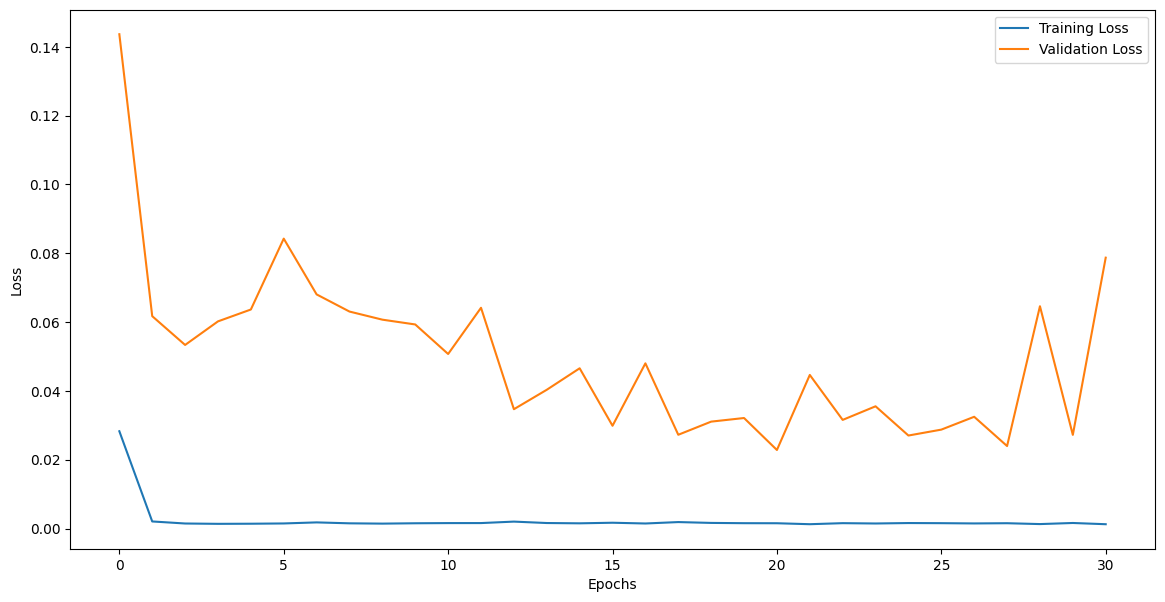

2023-07-16 23:53:04,431 [INFO] - Plotting completed
2023-07-16 23:53:04,432 [INFO] - Plotting predictions


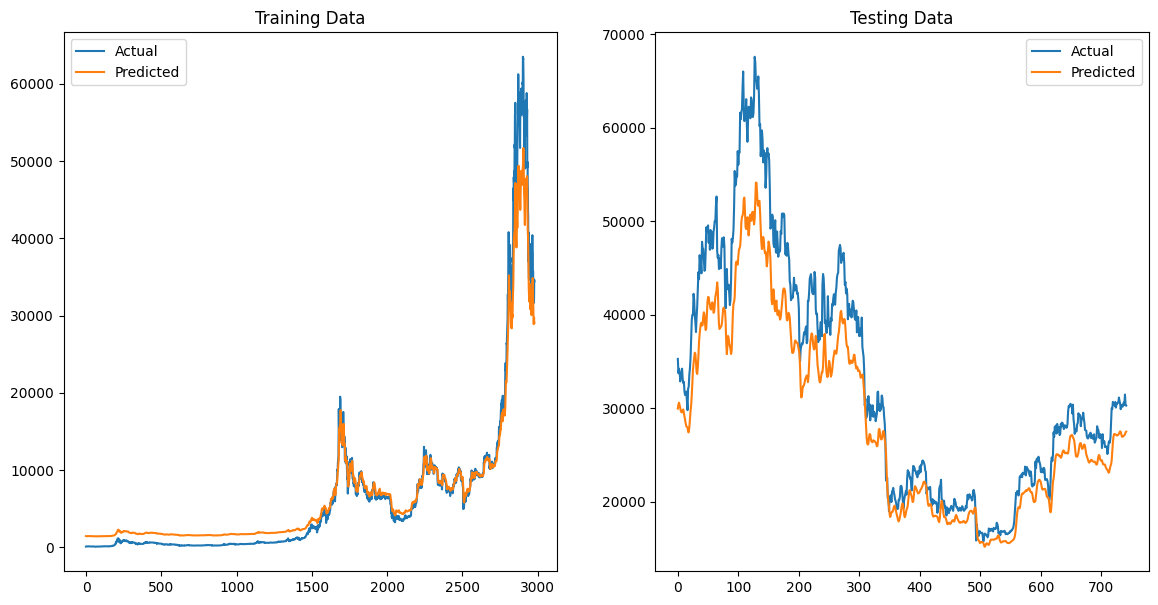

2023-07-16 23:53:04,800 [INFO] - Plotting completed


In [183]:
lstm_model1.evaluate_model()
lstm_model1.plot_history()
lstm_model1.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block X - Hardcoded Grid-Search For LSTM

In [91]:
best_score = float('inf')
best_model = None
best_params = None

# Define the grid
layer_grid = [[30], [50], [30, 30], [50, 50], [30, 50, 30]]

for layers in layer_grid:
    print(f"Training model with layers: {layers}")
    
    # Train the model
    model = LSTM_Models(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), 
                        units=layers, 
                        dropout=0.2, 
                        dense_units=1, 
                        optimizer='adam', 
                        scaler=preprocessor.scaler, 
                         X_train=X_train_rnn, 
                         y_train=y_train_rnn, 
                         X_test=X_test_rnn, 
                         y_test=y_test_rnn)
    model.train_model(epochs=100, batch_size=32, early_stopping=True)
    model.make_predictions()
    model.evaluate_model()

    # Check if this model is the best so far
    current_score = model.evaluation_df.loc['Test', 'RMSE']
    if current_score < best_score:
        best_score = current_score
        best_model = model
        best_params = layers

print(f"Best model has layers: {best_params} with RMSE: {best_score}")


Training model with layers: [30]
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 30)                3840      
                                                                 
 dropout_29 (Dropout)        (None, 30)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
75/75 [==============================] - 2s 14ms/step - loss: 0.1391 - val_loss: 1.2779
Epoch 2/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0121 - val_loss: 1.2215
Epoch 3/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0114 - v

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block X - Keras Tuner Grid-Search For LSTM

In [96]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, scaler):
        self.input_shape = input_shape
        self.scaler = scaler

    def build(self, hp):
        model = Sequential()
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=30, max_value=80, step=10),
                           activation=hp.Choice('activation_'+str(i), ['relu', 'tanh']),
                           input_shape=self.input_shape,
                           return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False))
            model.add(Dropout(rate=hp.Float('dropout_'+str(i), min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('dense_units', 1, 3), activation=hp.Choice('dense_activation', ['relu', 'linear'])))
        
        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                      loss='mean_squared_error')
        
        return model


In [97]:
hypermodel = LSTMHyperModel(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), scaler=preprocessor.scaler)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,  # adjust based on resources
    executions_per_trial=2,  # adjust based on resources
    directory='random_search',
    project_name='lstm'
)

tuner.search(X_train_rnn, y_train_rnn, epochs=50, validation_split=0.2)

Trial 10 Complete [00h 09m 01s]
val_loss: 0.0508728064596653

Best val_loss So Far: 0.02472236379981041
Total elapsed time: 01h 11m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [102]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

In [108]:
# Display the best model's architecture
best_model.summary()
# Display the best hyperparameters
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 60)             14880     
                                                                 
 dropout (Dropout)           (None, 5, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                22200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 37,131
Trainable params: 37,131
Non-trainable params: 0
_________________________________________________________________
{'num_layers': 2, 'units_0': 60, 'activation_0': 'ta

# Block 8 - Linear Model

# ------------------------------------------------------------------------------------------------------------------------------------------

In [184]:
class Linear_Regression:
    def __init__(self, X_train, y_train, X_test, y_test,cross_val=False):
        logger.info("Initializing Linear_Regression class")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cross_val = cross_val
        self.model = LinearRegression()

    def train_model(self):
        logger.info("Training Linear Regression model")
        
        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            fold_no = 1
            for train_index, test_index in tscv.split(self.X_train):
                logger.info(f"Performing cross validation on fold {fold_no}")
                cv_train_x, cv_val_x = self.X_train[train_index], self.X_train[test_index]
                cv_train_y, cv_val_y = self.y_train[train_index], self.y_train[test_index]
                self.model.fit(cv_train_x, cv_train_y)
                cv_val_predictions = self.model.predict(cv_val_x)
                cv_val_score = mean_squared_error(cv_val_y, cv_val_predictions, squared=False)
                logger.info(f"Cross-validation score on fold {fold_no}: {cv_val_score}")
                fold_no += 1
        else:
            self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        logger.info("Making predictions with Linear Regression model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

    def evaluate_model(self):
        logger.info("Evaluating Linear Regression model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.y_train, self.train_predictions, squared=False)
                test_evaluation = metric(self.y_test, self.test_predictions, squared=False)
            else:
                train_evaluation = metric(self.y_train, self.train_predictions)
                test_evaluation = metric(self.y_test, self.test_predictions)
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        return self.evaluation_df

    def plot_predictions(self):
        logger.info("Plotting predictions")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        ax[0].plot(self.y_train, label='Actual')
        ax[0].plot(self.y_train.index, self.train_predictions, label='Predicted')
        ax[0].set_title('Train Data: Actual vs Predicted')
        ax[0].legend()

        ax[1].plot(self.y_test, label='Actual')
        ax[1].plot(self.y_test.index, self.test_predictions, label='Predicted')
        ax[1].set_title('Test Data: Actual vs Predicted')
        ax[1].legend()

        plt.tight_layout()
        plt.show()
        
    def save_model(self):
        model_name = "linear_regression.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model



2023-07-16 23:53:13,674 [INFO] - Initializing Linear_Regression class
2023-07-16 23:53:13,675 [INFO] - Training Linear Regression model
2023-07-16 23:53:13,676 [INFO] - Performing cross validation on fold 1
2023-07-16 23:53:13,680 [INFO] - Cross-validation score on fold 1: 16.938199934880537
2023-07-16 23:53:13,681 [INFO] - Performing cross validation on fold 2
2023-07-16 23:53:13,684 [INFO] - Cross-validation score on fold 2: 25.39001720994029
2023-07-16 23:53:13,685 [INFO] - Performing cross validation on fold 3
2023-07-16 23:53:13,687 [INFO] - Cross-validation score on fold 3: 304.99193406662044
2023-07-16 23:53:13,688 [INFO] - Performing cross validation on fold 4
2023-07-16 23:53:13,693 [INFO] - Cross-validation score on fold 4: 208.3682253298121
2023-07-16 23:53:13,694 [INFO] - Performing cross validation on fold 5
2023-07-16 23:53:13,700 [INFO] - Cross-validation score on fold 5: 1237.5358056277123
2023-07-16 23:53:13,703 [INFO] - Model saved at trained_models\linear_regression.

          RMSE  R2 Score      MAE  Explained Variance
Train  508.069     0.998  170.940               0.998
Test  1945.265     0.977 1804.624               0.997


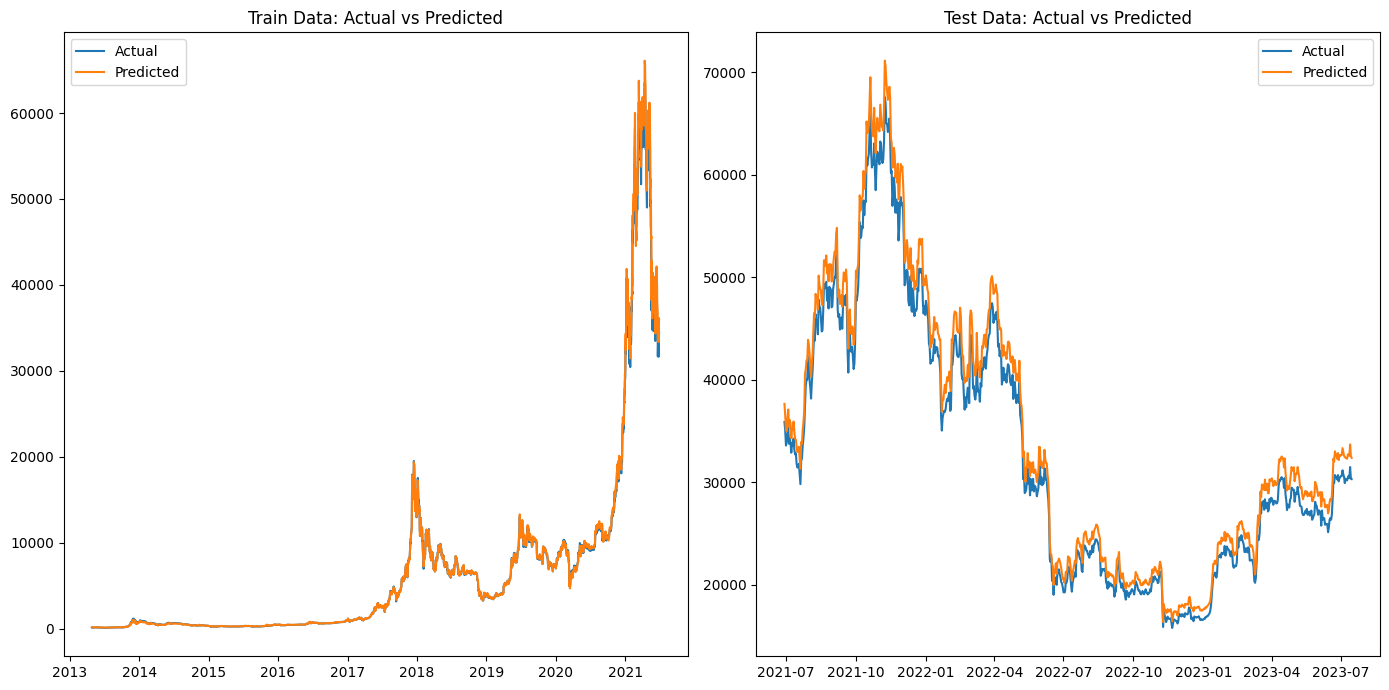

In [185]:
lr_model = Linear_Regression(X_train_lr, y_train_lr, X_test_lr, y_test_lr, cross_val=True)
lr_model.train_model()
lr_model.save_model()  # save the model
lr_model.make_predictions()
evaluation_df = lr_model.evaluate_model()
print(evaluation_df)
lr_model.plot_predictions()


# ------------------------------------------------------------------------------------------------------------------------------------------

# Block 8 - XGBoost Model

In [186]:
from sklearn.model_selection import TimeSeriesSplit

class XGBoostModel:
    def __init__(self, X_train, y_train, X_test, y_test, cross_val=False):
        logger.info("Initializing XGBoostModel class")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cross_val = cross_val
        self.model = XGBRegressor(objective='reg:squarederror')

    def train_model(self):
        logger.info("Training XGBoost model")

        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            fold_no = 1
            for train_index, test_index in tscv.split(self.X_train):
                logger.info(f"Performing cross validation on fold {fold_no}")
                cv_train_x, cv_val_x = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
                cv_train_y, cv_val_y = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
                self.model.fit(cv_train_x, cv_train_y)
                cv_val_predictions = self.model.predict(cv_val_x)
                cv_val_score = mean_squared_error(cv_val_y, cv_val_predictions, squared=False)
                logger.info(f"Cross-validation score on fold {fold_no}: {cv_val_score}")
                fold_no += 1
        else:
            self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

    def evaluate_model(self):
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.y_train, self.train_predictions, squared=False)
                test_evaluation = metric(self.y_test, self.test_predictions, squared=False)
            else:
                train_evaluation = metric(self.y_train, self.train_predictions)
                test_evaluation = metric(self.y_test, self.test_predictions)
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        return self.evaluation_df

    def plot_predictions(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        ax[0].plot(self.y_train, label='Actual')
        ax[0].plot(self.y_train.index, self.train_predictions, label='Predicted')
        ax[0].set_title('Train Data: Actual vs Predicted')
        ax[0].legend()

        ax[1].plot(self.y_test, label='Actual')
        ax[1].plot(self.y_test.index, self.test_predictions, label='Predicted')
        ax[1].set_title('Test Data: Actual vs Predicted')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def save_model(self):
        model_name = "xgboost_model.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model

2023-07-16 23:53:14,869 [INFO] - Initializing XGBoostModel class
2023-07-16 23:53:14,872 [INFO] - Training XGBoost model
2023-07-16 23:53:15,212 [INFO] - Model saved at trained_models\xgboost_model.joblib


          RMSE  R2 Score     MAE  Explained Variance
Train   21.369     1.000  13.604               1.000
Test  1110.047     0.992 851.442               0.993


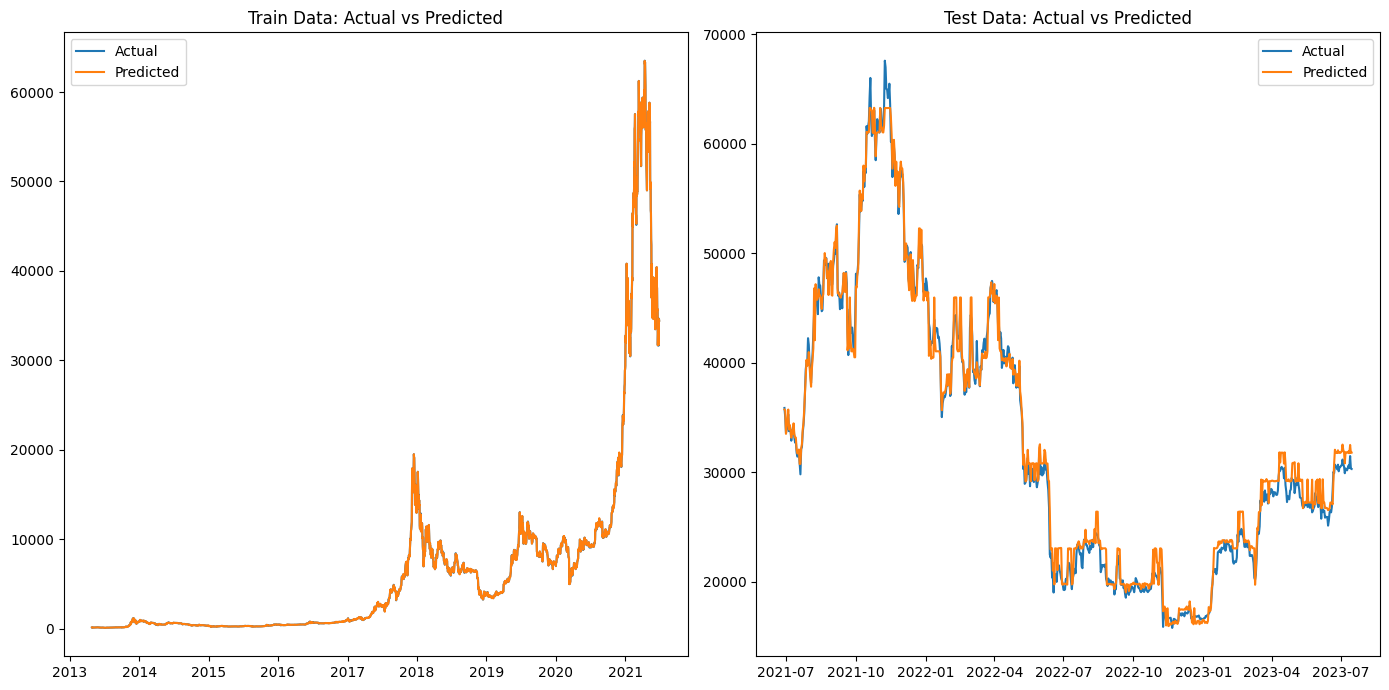

In [187]:
xgb_model = XGBoostModel(X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb,cross_val=False)
xgb_model.train_model()
xgb_model.save_model()  # save the model
xgb_model.make_predictions()
evaluation_df = xgb_model.evaluate_model()
print(evaluation_df)
xgb_model.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block 8 - LightGBM Model

In [188]:
class LightGBMModel:
    def __init__(self, X_train, y_train, X_test, y_test, cross_val=False):
        logger.info("Initializing LightGBMModel class")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cross_val = cross_val
        self.model = LGBMRegressor()

    def train_model(self):
        logger.info("Training LightGBM model")

        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            fold_no = 1
            for train_index, test_index in tscv.split(self.X_train):
                logger.info(f"Performing cross validation on fold {fold_no}")
                cv_train_x, cv_val_x = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
                cv_train_y, cv_val_y = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
                self.model.fit(cv_train_x, cv_train_y)
                cv_val_predictions = self.model.predict(cv_val_x)
                cv_val_score = mean_squared_error(cv_val_y, cv_val_predictions, squared=False)
                logger.info(f"Cross-validation score on fold {fold_no}: {cv_val_score}")
                fold_no += 1
        else:
            self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        logger.info("Making predictions with LightGBM model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

    def evaluate_model(self):
        logger.info("Evaluating LightGBM model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.y_train, self.train_predictions, squared=False)
                test_evaluation = metric(self.y_test, self.test_predictions, squared=False)
            else:
                train_evaluation = metric(self.y_train, self.train_predictions)
                test_evaluation = metric(self.y_test, self.test_predictions)
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        return self.evaluation_df

    def plot_predictions(self):
        logger.info("Plotting predictions")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        ax[0].plot(self.y_train, label='Actual')
        ax[0].plot(self.y_train.index, self.train_predictions, label='Predicted')
        ax[0].set_title('Train Data: Actual vs Predicted')
        ax[0].legend()

        ax[1].plot(self.y_test, label='Actual')
        ax[1].plot(self.y_test.index, self.test_predictions, label='Predicted')
        ax[1].set_title('Test Data: Actual vs Predicted')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def save_model(self):
        model_name = "lightgbm_model.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model


2023-07-16 23:53:16,968 [INFO] - Initializing LightGBMModel class
2023-07-16 23:53:16,970 [INFO] - Training LightGBM model
2023-07-16 23:53:17,086 [INFO] - Model saved at trained_models\lightgbm_model.joblib
2023-07-16 23:53:17,086 [INFO] - Making predictions with LightGBM model
2023-07-16 23:53:17,096 [INFO] - Evaluating LightGBM model
2023-07-16 23:53:17,106 [INFO] - Plotting predictions


          RMSE  R2 Score      MAE  Explained Variance
Train  183.575     1.000   60.588               1.000
Test  1518.024     0.986 1100.968               0.986


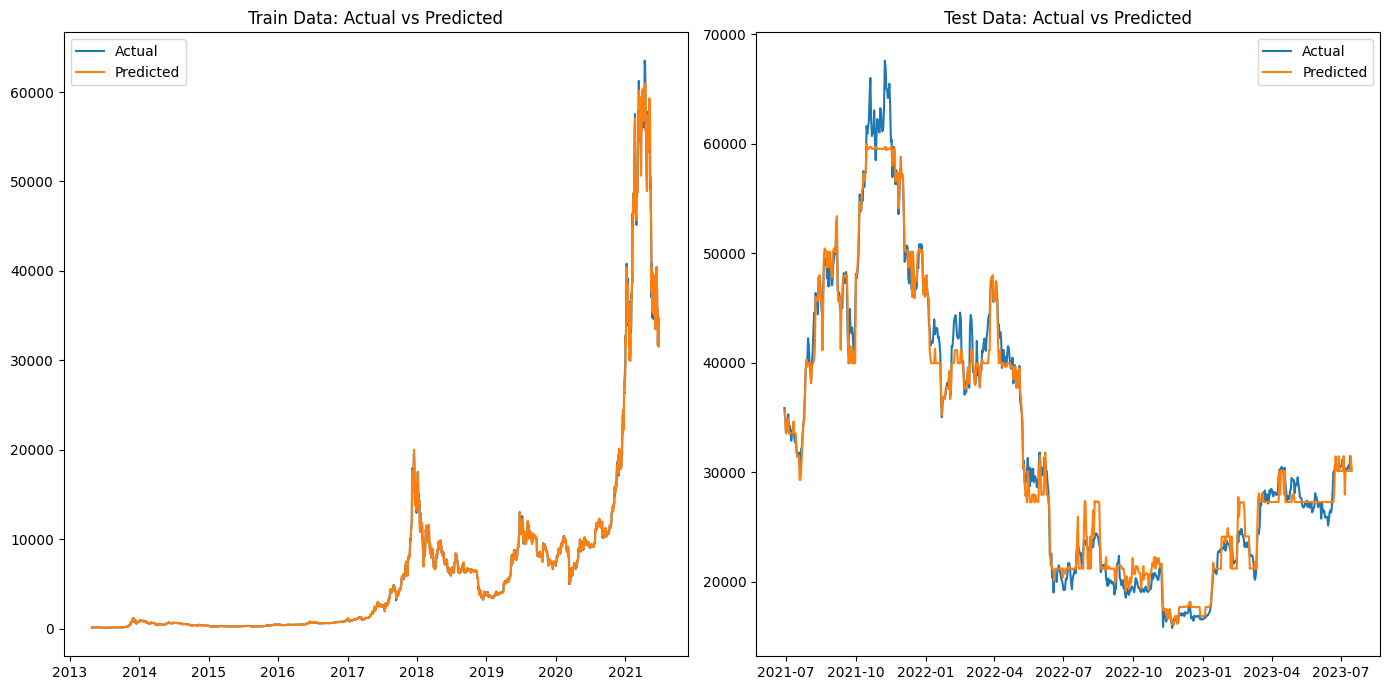

In [189]:
lgb_model = LightGBMModel(X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, cross_val=False)
lgb_model.train_model()
lgb_model.save_model()  # save the model
lgb_model.make_predictions()
evaluation_df = lgb_model.evaluate_model()
print(evaluation_df)
lgb_model.plot_predictions()


# ------------------------------------------------------------------------------------------------------------------------------------------

# Block 8 - AutoArima

In [54]:
# Assuming 'Close' is your target column
preprocessor = DataPreprocessing(data, ['Close'])
scaled_data = preprocessor.data_scaled
train_data, test_data = preprocessor.split_data(test_size=0.2)
y_train, y_test, X_train, X_test = preprocessor.prepare_data_SARIMAX('Close', ['Volume'])
y_train, y_test, X_train, X_test = preprocessor.prepare_data_SARIMAX('Close')

2023-07-16 21:56:29,265 [INFO] - Initializing DataPreprocessing class
2023-07-16 21:56:29,267 [INFO] - Loading scaler
2023-07-16 21:56:29,269 [INFO] - Scaler loaded from ./scaler.pkl
2023-07-16 21:56:29,271 [INFO] - Splitting data
2023-07-16 21:56:29,272 [INFO] - Preparing data for SARIMAX
2023-07-16 21:56:29,275 [INFO] - SARIMAX Data Shape - y: (2984,), (747,)
2023-07-16 21:56:29,276 [INFO] - Preparing data for SARIMAX
2023-07-16 21:56:29,277 [INFO] - SARIMAX Data Shape - y: (2984,), (747,)


In [55]:
class SARIMAModel:
    def __init__(self, train, test, exog_train=None, exog_test=None):
        logger.info("Initializing SARIMAModel class")
        self.train = train
        self.test = test
        self.exog_train = exog_train
        self.exog_test = exog_test
        self.model = None
        self.predictions = None

    def auto_fit(self, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True):
        logger.info("Starting auto_fit...")
        try:
            self.model = pm.auto_arima(self.train, exogenous=self.exog_train, seasonal=seasonal, m=m, trace=trace, error_action=error_action, suppress_warnings=suppress_warnings)
            logger.info("Auto_fit completed successfully.")
        except Exception as e:
            logger.error(f"Auto_fit failed with error: {e}")
            raise

    def make_predictions(self,start, end):
        if self.model is None:
            logger.error("Model not fitted yet.")
            return
        logger.info("Making predictions...")
        self.predictions = self.model.predict(n_periods=len(self.test), exogenous=self.exog_test)
        return self.predictions
    
    def evaluate_model(self):
        if self.model is None or self.predictions is None:
            logger.error("Model not fitted or predictions not made yet.")
            return
        mse = mean_squared_error(self.test, self.predictions)
        mae = mean_absolute_error(self.test, self.predictions)
        r2 = r2_score(self.test, self.predictions)
        
        logger.info(f'MSE: {mse}')
        logger.info(f'MAE: {mae}')
        logger.info(f'R2 Score: {r2}')

    def plot_predictions(self):
        if self.model is None or self.predictions is None:
            logger.error("Model not fitted or predictions not made yet.")
            return
        logger.info("Plotting predictions")
        plt.figure(figsize=(10,5))
        plt.plot(self.test, label='Actual')
        plt.plot(self.predictions, label='Predicted')
        plt.title('Test Data vs Predicted Data')
        plt.legend()
        plt.show()

    def save_model(self):
        model_name = "sarima_model.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model

2023-07-16 21:56:30,803 [INFO] - Initializing SARIMAModel class
2023-07-16 21:56:30,804 [INFO] - Starting auto_fit...


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=46323.223, Time=9.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=46496.364, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=46434.085, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=46441.126, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46495.512, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=46424.372, Time=3.02 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=46419.077, Time=2.08 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=46393.381, Time=12.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=46391.958, Time=16.72 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=46469.169, Time=0.87 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=46417.909, Time=13.94 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=46411.778, Time=5.66 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=20.75 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=46389.586, Time=1.77 sec
 ARIMA(

2023-07-16 22:06:10,626 [INFO] - Auto_fit completed successfully.
2023-07-16 22:06:11,443 [INFO] - Model saved at trained_models\sarima_model.joblib
2023-07-16 22:06:11,474 [INFO] - Making predictions...
2023-07-16 22:06:11,530 [INFO] - MSE: 464987015.81975347
2023-07-16 22:06:11,531 [INFO] - MAE: 18629.98855931721
2023-07-16 22:06:11,531 [INFO] - R2 Score: -1.857509315126709
2023-07-16 22:06:11,533 [INFO] - Plotting predictions


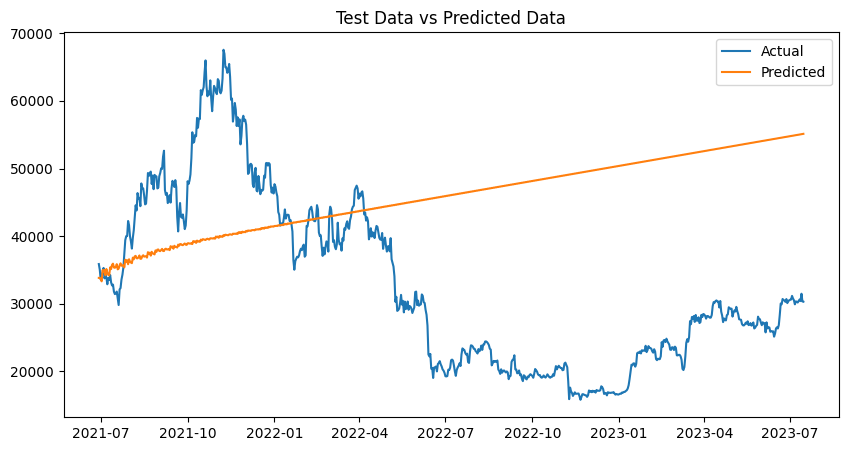

In [56]:
# Initialize the SARIMAModel class
model = SARIMAModel(y_train, y_test)# Fit the SARIMA model with seasonal set to True and m set to 12 for monthly data
model.auto_fit(seasonal=True, m=12)
model.save_model()  # save the model
# Make predictions for the length of the test set
model.make_predictions(start=len(y_train), end=len(y_train) + len(y_test) - 1)
# Evaluate the model
model.evaluate_model()
# Plot the actual vs predicted values
model.plot_predictions()

# Block 8 - FB Prophet Models

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


class ProphetModel:
    def __init__(self, df):
        df.reset_index(level=0, inplace=True)
        self.df = df.rename(columns={"Date": "ds", "Close": "y"})
        self.model = Prophet()

    def train_model(self):
        self.model.fit(self.df)

    def make_forecast(self, periods):
        future = self.model.make_future_dataframe(periods=periods)
        forecast = self.model.predict(future)
        self.forecast = forecast
        return forecast  # Return the forecast DataFrame


    def plot_forecast(self):
        return self.model.plot(self.forecast)

    def evaluate_model(self):
        df_cv = cross_validation(self.model, horizon='30 days')
        df_p = performance_metrics(df_cv)
        
        rmse = np.mean(df_p['rmse'])
        mae = np.mean(df_p['mae'])
        mse = np.mean(df_p['mse'])
        r2 = np.mean(df_p['coverage'])

        eval_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Value': [rmse, mae, mse, r2]
        })

        return eval_df

    def plot_residuals(self):
        df_res = self.df.copy()
        df_res['yhat'] = self.forecast['yhat']
        df_res['residuals'] = df_res['y'] - df_res['yhat']
        plt.figure(figsize=(10,6))
        plt.plot(df_res['ds'], df_res['residuals'], label='Residuals')
        plt.title('Residuals over time')
        plt.show()
    
    def get_predictions_df(self, periods):
        df_pred = self.make_forecast(periods)
        compare_df = df_pred.set_index('ds')[['yhat']].join(self.df.set_index('ds'))
        compare_df = compare_df.rename(columns={'yhat': 'Predicted', 'y': 'Actual'})
        return compare_df


In [ ]:
# Create an instance of the ProphetModel class
univariate_model = ProphetModel(data)
# Train the model
univariate_model.train_model()
# Make a forecast
univariate_model.make_forecast(30) # adjust the number of periods as needed
# Evaluate the model
evaluation = univariate_model.evaluate_model()
print(evaluation)
# Plot residuals
univariate_model.plot_residuals()
# Get the predictions DataFrame
predictions_df = univariate_model.get_predictions_df(30) # adjust the number of periods as needed
print(predictions_df)

# Block 9 - AMZ Deep Time Models

In [ ]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

class DeepTimeModel:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
        self.model = None
        self.predictor = None
        self.forecast = None

    def train_model(self, prediction_length):
        dataset = ListDataset([{
            "start": self.df.index[0],
            "target": self.df[self.column_name]
        }], freq = "D")
        
        estimator = DeepAREstimator(freq="D", 
                                    prediction_length=prediction_length, 
                                    trainer=Trainer(epochs=10))
        self.model = estimator.train(training_data=dataset)
    
    def get_predictions(self, test_data):
        predictor = self.model.predict(test_data)
        self.predictor = predictor
        return predictor


In [ ]:
# Create an instance of the DeepTimeModel class
deeptime_model = DeepTimeModel(df, 'column_name')
# Train the model
deeptime_model.train_model(prediction_length=30)
# Get the predictions
predictions = deeptime_model.get_predictions(test_data)
